In [20]:
#importing the necessary lib
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,CuDNNLSTM,SpatialDropout1D
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from keras.initializers import he_normal
from keras.callbacks import Callback, EarlyStopping
from time import time
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.regularizers import l2
import pickle

In [2]:
#Reading the dataset
project_data = pd.read_csv('processed_train_data.csv')
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,...,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity,presence_of_the_numerical_digits
0,0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,students english learners working english seco...,154.60,23,0
1,1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,wanted projector hungry learners,...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,students arrive school eager learn polite gene...,299.00,1,0
2,2,p182444,3465aaf82da834c0582ebd0ef8040ca0,ms,az,2016-08-31 12:03:56,grades_6_8,health_sports,health_wellness_teamsports,soccer equipment awesome middle school students,...,The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,true champions not always ones win guts mia ha...,516.85,22,0


In [3]:
#combining teacher number of previously posted projects, presence of the numberical digits price and quantity into a single feature
project_data.drop(['Unnamed: 0'], axis =1 , inplace = True)
class_label = project_data['project_is_approved']
project_data['remaining_input'] = project_data['teacher_number_of_previously_posted_projects']  +\
                                    project_data['presence_of_the_numerical_digits']  + \
                                    project_data['price'] + project_data['quantity']

In [4]:
#train test split
train,test,y_train,y_test = train_test_split(project_data, class_label , stratify = class_label, train_size = 0.7)

In [5]:
train,cv,y_train,y_cv = train_test_split(train,y_train,stratify = y_train,train_size = 0.8)

In [6]:
print("Shape of the Train dataset: ", train.shape[0])
print("Shape of the Test dataset: ", test.shape[0])
print("Shape of the CV Dataset:", cv.shape[0])

Shape of the Train dataset:  61178
Shape of the Test dataset:  32775
Shape of the CV Dataset: 15295


In [7]:
# converting the class labels to one hot encoding for keras model evaluation
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)

In [24]:
# reading the pre trained word vectors file
dbfile = open('glove_vectors.pickle', 'rb')      
db = pickle.load(dbfile) 

In [22]:
# creating a matrix of word as rows and columns as 50 dmin vectors of words
def embedding_mat(word_index,embedding_dim = 300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector =db.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Selecting the Top features based on IDF values for the Text part of the project_data

Text(0,0.5,'IDF score')

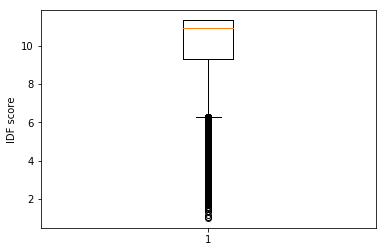

In [10]:
#tfidf vectorization of text data
tfidf = TfidfVectorizer()
data_text = tfidf.fit_transform(train['essay'])
plt.boxplot(tfidf.idf_)
plt.ylabel("IDF score")

In [11]:
print("The 25 percentile of idf score is :", np.percentile(tfidf.idf_,[25]))
print("The 75 percentile of idf score is :",np.percentile(tfidf.idf_,[75]))

The 25 percentile of idf score is : [9.31350907]
The 75 percentile of idf score is : [11.32841209]


- Selecting the features based on idf score. All the features with idf score between 7.21480808 and 8.82424599 are selected for the model 2.

In [12]:
feature_idf = zip(tfidf.get_feature_names(),tfidf.idf_)

feature_name = []
for x,y in feature_idf:
    
    if y >=9.31350907 and 11.32841209 :
        feature_name.append(x)
    else:
        pass

In [13]:
#Selecting only those words which have idf values between 25th percentile to 75th percentile
def few_text(df):
    processed_text = []
    for text in df:
        sent = " "
        words = text.split()
        for word in words:
            if word in feature_name:
                sent = ' ' + word
            else:
                pass
        processed_text.append(sent)
    return processed_text

train['processed_essay'] = few_text(train['essay'])
test['processed_essay'] = few_text(test['essay'])
cv['processed_essay'] = few_text(cv['essay'])

train.to_csv("model-train.csv")
test.to_csv("model-test.csv")
cv.to_csv("model-cv.csv")

In [2]:
train = pd.read_csv("model-train.csv")
test = pd.read_csv("model-test.csv")
cv = pd.read_csv("model-cv.csv")

In [3]:
train['total_txt'] = train['project_title'] + ' ' + train['essay'] + ' ' + train['project_resource_summary']
test['total_txt'] = test['project_title'] + ' ' + test['essay'] + ' ' + test['project_resource_summary']
cv['total_txt'] = cv['project_title'] + ' ' + cv['essay'] + ' ' + cv['project_resource_summary']

In [4]:
y_train = train['project_is_approved']
y_test = test['project_is_approved']
y_cv = cv['project_is_approved']

# converting the class labels to one hot encoding for keras model evaluation
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)

In [5]:
def word_ranking(train,test,cv):
    col_names = train.columns
    features = []
    #performing train test split
    
    for col in col_names[:6]:
        print(col)
        bag_of_words = CountVectorizer(lowercase= False)
        bow_words = bag_of_words.fit_transform(train[col])
        print(bow_words.shape)
        
        #Lets now store the document term matrix in a dictionary.
        freqs = bow_words.sum(axis=0).A1
        index = freqs.argsort()
        words = bag_of_words.get_feature_names()
        
        

        # Assigning Rank to each word based on its freq of occurance. Word with highest freq is assigned rank 1 
        word_rank = dict()
        rank = 1
        for i in index[::-1]:
            k = words[i]
            word_rank[k] = rank
            rank+=1
        features.append(word_rank)

        #Every word in each review is replaced by its rank
        rank = [] # list of all the review with words replaced with rank
        for sent in train[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        train[col] = rank
        
        rank = [] # list of all the review with words replaced with rank
        for sent in test[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        test[col] = rank
        
        rank = [] # list of all the review with words replaced with rank
        for sent in cv[col].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        cv[col] = rank
    return train,test,cv,features
            

In [6]:
col = ['id','teacher_id','project_submitted_datetime','project_title','project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4','project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved','price', 'quantity',
        'presence_of_the_numerical_digits','essay']

train.drop(labels=col,axis =1, inplace=True)
test.drop(labels=col,axis =1, inplace=True)
cv.drop(labels=col,axis =1, inplace=True)

In [7]:
col = train.columns

In [8]:
col = ['teacher_prefix', 'school_state', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories','total_txt',
       'remaining_input']
train = train[col]
test = test[col]
test = test[col]

In [9]:
train.replace(to_replace=np.NaN, value= str('nan'),inplace=True)
test.replace(to_replace=np.NaN, value= str('nan'),inplace=True)
cv.replace(to_replace=np.NaN, value= str('nan'),inplace=True)

In [10]:
train,test,cv,feature_names =  word_ranking(train,test,cv)

teacher_prefix
(61178, 5)
school_state
(61178, 51)
project_grade_category
(61178, 4)
project_subject_categories
(61178, 50)
project_subject_subcategories
(61178, 380)
total_txt
(61178, 56912)


# Tokenizing the Test part

In [11]:

max_review_length = 250
X_train = pad_sequences(train['total_txt'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test = pad_sequences(test['total_txt'], maxlen=max_review_length)
X_cv = pad_sequences(cv['total_txt'], maxlen=max_review_length)
print(X_train.shape)
print(X_train[256])

(61178, 250)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  180   19  132    1  368    2   28   23  111
  151   11   99   68   52 1638    2   73   30 1816    1   78    4  580
 1373 1808  427    1   45   17    7 1285  432  294    5   17  123  103
   72 2069  323 2305    1   56  461    1   25  260  863  572 2973 4302
    5  247    4  863  287    1  119  645  811   27  714   76  119  697
  579   24  486   74  119  229 2973 4302  287    1  533  497    

# Tokenizing the school state

In [12]:

max_review_length = 1
X_train_school_state = pad_sequences(train['school_state'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_school_state = pad_sequences(test['school_state'], maxlen=max_review_length)
X_cv_school_state = pad_sequences(cv['school_state'], maxlen=max_review_length)
print(X_test_school_state.shape)
print(X_test_school_state[0])

(32775, 1)
[2]


# Tokenizing the project_grade_category

In [13]:
max_review_length = 1
X_train_project_grade = pad_sequences(train['project_grade_category'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_project_grade = pad_sequences(test['project_grade_category'], maxlen=max_review_length)
X_cv_project_grade = pad_sequences(cv['project_grade_category'], maxlen=max_review_length)
print(X_train_project_grade.shape)
print(X_train_project_grade[0])

(61178, 1)
[1]


# Tokenizing the project categories

In [14]:
max_review_length = 1
X_train_project_cat = pad_sequences(train['project_subject_categories'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_project_cat = pad_sequences(test['project_subject_categories'], maxlen=max_review_length)
X_cv_project_cat = pad_sequences(cv['project_subject_categories'], maxlen=max_review_length)
print(X_train_project_cat.shape)
print(X_train_project_cat[0])

(61178, 1)
[2]


# Tokenizing the project subcategories

In [15]:
max_review_length = 1
X_train_project_subcat = pad_sequences(train['project_subject_subcategories'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_project_subcat = pad_sequences(test['project_subject_subcategories'], maxlen=max_review_length)
X_cv_project_subcat = pad_sequences(cv['project_subject_subcategories'], maxlen=max_review_length)
print(X_train_project_subcat.shape)
print(X_train_project_subcat[0])

(61178, 1)
[5]


# Tokenizing the teacher prefix

In [16]:
max_review_length = 1
X_train_teacher_prefix = pad_sequences(train['teacher_prefix'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_teacher_prefix = pad_sequences(test['teacher_prefix'], maxlen=max_review_length)
X_cv_teacher_prefix = pad_sequences(cv['teacher_prefix'], maxlen=max_review_length)
print(X_train_teacher_prefix.shape)
print(X_test_teacher_prefix[0])

(61178, 1)
[2]


In [17]:
train.head()


,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,total_txt,remaining_input
0,[1],[31],[1],[2],[5],"[758, 33, 863, 33, 6464, 33, 5526, 112, 286, 2...",147.89
1,[1],[12],[2],[17],[36],"[1747, 1035, 365, 122, 1, 6037, 1041, 365, 122...",135.39
2,[1],[8],[3],[37],[220],"[246, 282, 1085, 763, 79, 96, 144, 47, 135, 2,...",457.30
3,[1],[20],[2],[3],[2],"[6784, 1191, 1366, 2463, 344, 332, 52, 1, 198,...",57.99
4,[1],[19],[2],[9],[126],"[11130, 1191, 58, 5811, 824, 1, 23, 96, 144, 3...",444.04


# Deep Learning Models

 ### Model 1

In [18]:
#AUC score
def auc( y_true, y_pred ) :
    score = tf.py_func( lambda y_true, y_pred : roc_auc_score( y_true, y_pred ,average='weighted').astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        stateful=True,
                        name='sklearnAUC' )
    return score

In [28]:
#input 1
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=56913,output_dim= 300,weights=[embedding_mat(feature_names[5])],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = CuDNNLSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52,output_dim= 2)(input2)
#x2 = SpatialDropout1D(0.3)(x2)
x2 = Flatten()(x2)

#input 3
input3 = Input(shape=(1,))
x3 = Embedding(input_dim= 5,output_dim= 2)(input3)
#x3 = SpatialDropout1D(0.3)(x3)
x3 = Flatten()(x3)

#input 4
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=50,output_dim= 2)(input4)
#x4 = SpatialDropout1D(0.3)(x4)
x4 = Flatten()(x4)

#input 5
input5 = Input(shape=(1,))
x5 = Embedding(input_dim= 385,output_dim= 50)(input5)
#x5 = SpatialDropout1D(0.3)(x5)
x5 = Flatten()(x5)

#input 6
input6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 5)(input6)
#x6 = SpatialDropout1D(0.3)(x6)
x6 = Flatten()(x6)

#input 7
input7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
#x7 = Flatten()(x7)
#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=[auc])
#lrate = LearningRateScheduler(step_decay)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 250, 300)     17073900    input_11[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 250, 300)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_13 (

In [29]:
#model fitting
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="weights_2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]
model.fit([X_train,X_train_school_state,X_train_project_grade,X_train_project_cat,X_train_project_subcat,
           X_train_teacher_prefix,train['remaining_input']], y_train, nb_epoch=50,verbose=1,batch_size=256,
          validation_data=([X_cv,X_cv_school_state,X_cv_project_grade,X_cv_project_cat,X_cv_project_subcat,
           X_cv_teacher_prefix,cv['remaining_input']]  , y_cv),callbacks =callbacks_list )

Train on 61178 samples, validate on 15295 samples
Epoch 1/50
61178/61178 [==============================] - 28s 461us/step - loss: 0.6874 - auc: 0.5077 - val_loss: 0.4759 - val_auc: 0.5832

Epoch 00001: val_auc improved from -inf to 0.58320, saving model to weights_2.best.hdf5
Epoch 2/50
61178/61178 [==============================] - 27s 433us/step - loss: 0.5224 - auc: 0.5228 - val_loss: 0.4537 - val_auc: 0.6028

Epoch 00002: val_auc improved from 0.58320 to 0.60285, saving model to weights_2.best.hdf5
Epoch 3/50
61178/61178 [==============================] - 27s 435us/step - loss: 0.4816 - auc: 0.5384 - val_loss: 0.4451 - val_auc: 0.6168

Epoch 00003: val_auc improved from 0.60285 to 0.61685, saving model to weights_2.best.hdf5
Epoch 4/50
61178/61178 [==============================] - 27s 436us/step - loss: 0.4636 - auc: 0.5489 - val_loss: 0.4436 - val_auc: 0.6200

Epoch 00004: val_auc improved from 0.61685 to 0.61998, saving model to weights_2.best.hdf5
Epoch 5/50
61178/61178 [=====

61178/61178 [==============================] - 27s 443us/step - loss: 0.3180 - auc: 0.8483 - val_loss: 0.4003 - val_auc: 0.7420

Epoch 00040: val_auc did not improve from 0.76645
Epoch 41/50
61178/61178 [==============================] - 27s 444us/step - loss: 0.3150 - auc: 0.8518 - val_loss: 0.4068 - val_auc: 0.7370

Epoch 00041: val_auc did not improve from 0.76645
Epoch 42/50
61178/61178 [==============================] - 27s 443us/step - loss: 0.3108 - auc: 0.8564 - val_loss: 0.4056 - val_auc: 0.7371

Epoch 00042: val_auc did not improve from 0.76645
Epoch 43/50
61178/61178 [==============================] - 27s 443us/step - loss: 0.3053 - auc: 0.8634 - val_loss: 0.4161 - val_auc: 0.7252

Epoch 00043: val_auc did not improve from 0.76645
Epoch 44/50
61178/61178 [==============================] - 27s 443us/step - loss: 0.3005 - auc: 0.8686 - val_loss: 0.4169 - val_auc: 0.7277

Epoch 00044: val_auc did not improve from 0.76645
Epoch 45/50
61178/61178 [==============================] 

# Defining the model with best obtained weights

In [32]:
#input 1
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=56913,output_dim= 300,weights=[embedding_mat(feature_names[5])],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = CuDNNLSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52,output_dim= 2)(input2)
#x2 = SpatialDropout1D(0.3)(x2)
x2 = Flatten()(x2)

#input 3
input3 = Input(shape=(1,))
x3 = Embedding(input_dim= 5,output_dim= 2)(input3)
#x3 = SpatialDropout1D(0.3)(x3)
x3 = Flatten()(x3)

#input 4
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=50,output_dim= 2)(input4)
#x4 = SpatialDropout1D(0.3)(x4)
x4 = Flatten()(x4)

#input 5
input5 = Input(shape=(1,))
x5 = Embedding(input_dim= 385,output_dim= 50)(input5)
#x5 = SpatialDropout1D(0.3)(x5)
x5 = Flatten()(x5)

#input 6
input6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 5)(input6)
#x6 = SpatialDropout1D(0.3)(x6)
x6 = Flatten()(x6)

#input 7
input7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
#x7 = Flatten()(x7)
#merging all the inputs 
concat = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)
model.load_weights("weights_2.best.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=[auc])


In [33]:
print("Auc for test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test,X_test_school_state,X_test_project_grade,X_test_project_cat,X_test_project_subcat,
          X_test_teacher_prefix,test['remaining_input']])))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv,X_cv_school_state,X_cv_project_grade,X_cv_project_cat,X_cv_project_subcat,
           X_cv_teacher_prefix,cv['remaining_input']])))
print("Auc for train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train,X_train_school_state,X_train_project_grade,X_train_project_cat,X_train_project_subcat,
           X_train_teacher_prefix,train['remaining_input']])))

Auc for test data: 0.766
Auc for CV data: 0.766
Auc for train data: 0.818


<img src = 'model_2_epoch_auc_loss.jpg'>
<img src = 'model_2_epoch_val_auc_loss.jpg'>